<a href="https://colab.research.google.com/github/pathdata/ImageAnnotator/blob/master/bioml_prediction_linear_algebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# Training data
train_X = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=np.float32)
train_Y = np.array([-1.5, 0.0, 1.5, 3.0, 4.5, 6.0], dtype=np.float32)


In [3]:
# Method 1: Using the same random seed for each optimizer
def set_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    tf.random.set_seed(seed)


# Test different optimizers with same initialization
def get_optimizer(name, learning_rate=0.01):
    """Create a new optimizer instance"""
    optimizers = {
        'SGD': keras.optimizers.SGD(learning_rate=learning_rate),
        'Adam': keras.optimizers.Adam(learning_rate=learning_rate),
        'Adagrad': keras.optimizers.Adagrad(learning_rate=learning_rate),
        'RMSprop': keras.optimizers.RMSprop(learning_rate=learning_rate)
    }
    return optimizers[name]

optimizer_names = ['SGD', 'Adam', 'Adagrad', 'RMSprop']
epochs = 200
results = {}

print("Fair Optimizer Comparison Results:")
print("=" * 50)


Fair Optimizer Comparison Results:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


SGD     : m =  1.4845, c =  0.0480, final_loss = 0.001343
Adam    : m =  1.4441, c =  0.1364, final_loss = 0.012190
Adagrad : m =  0.6280, c =  0.2464, final_loss = 3.351187
RMSprop : m =  1.4950, c = -0.0050, final_loss = 0.000229


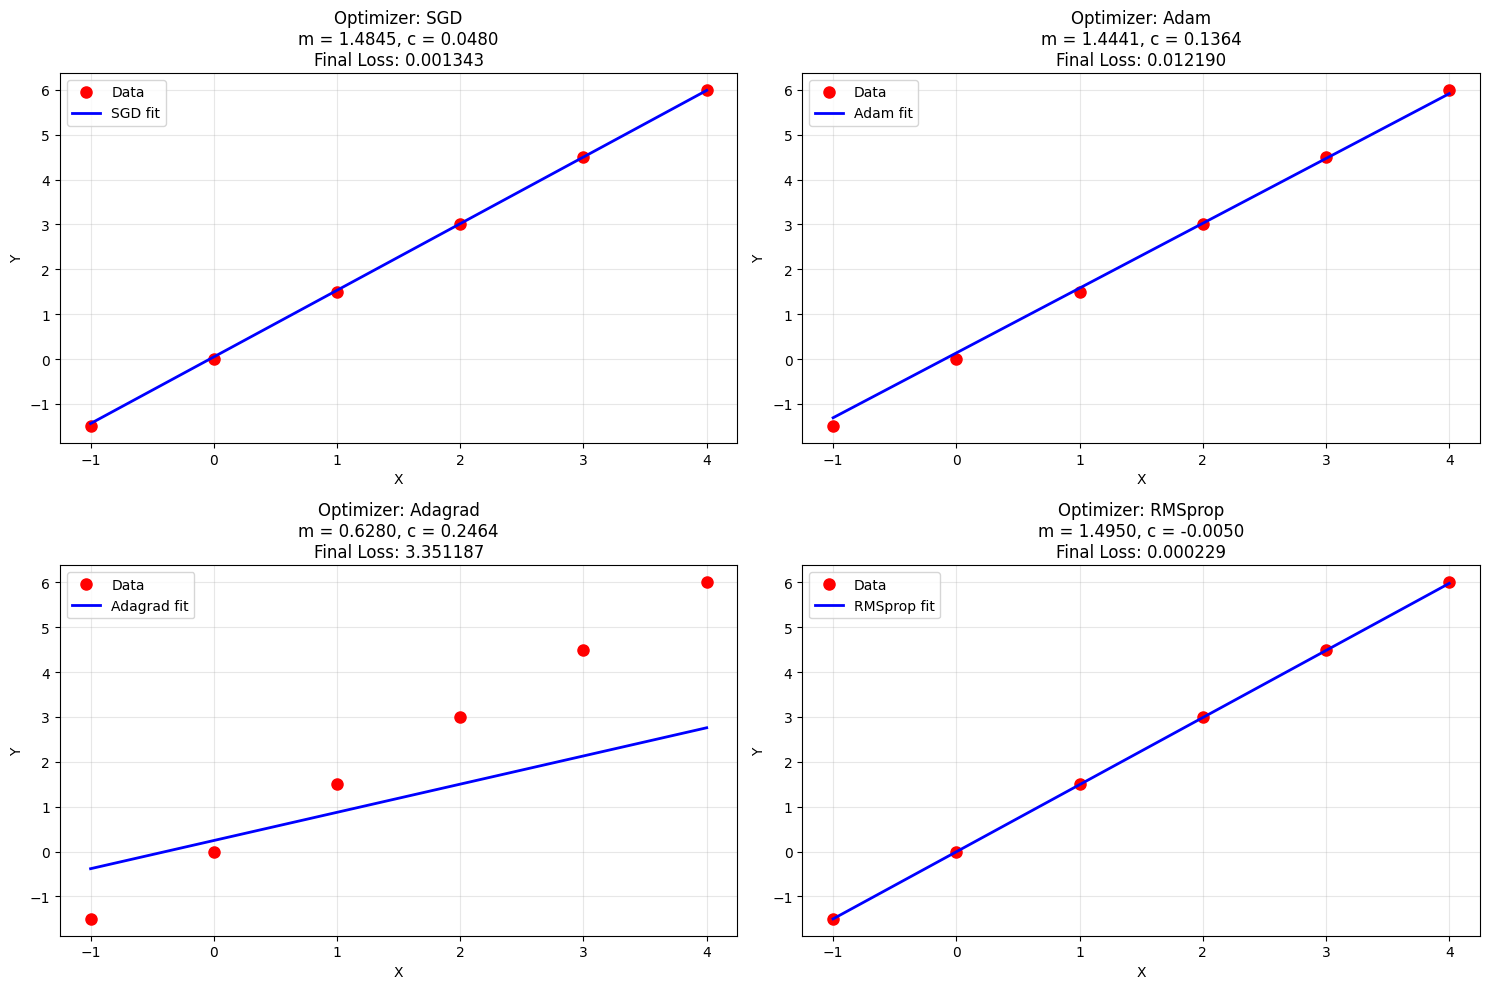

In [6]:
optimizers_to_test = [
    ('SGD', keras.optimizers.SGD(learning_rate=0.01)),
    ('Adam', keras.optimizers.Adam(learning_rate=0.01)),
    ('Adagrad', keras.optimizers.Adagrad(learning_rate=0.01)),
    ('RMSprop', keras.optimizers.RMSprop(learning_rate=0.01))
]

plt.figure(figsize=(15, 10))

for idx, (name, optimizer) in enumerate(optimizers_to_test):
    # Set the same seed before creating each model
    set_seeds(42)

    # Create new model for each optimizer
    model = keras.Sequential([
        layers.Dense(1, input_shape=(1,))
    ])

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train with same number of epochs
    history = model.fit(train_X, train_Y, epochs=epochs, verbose=0)

    # Extract learned parameters
    weight = model.get_weights()[0][0][0]  # slope (m)
    bias = model.get_weights()[1][0]  # intercept (c)
    final_loss = history.history['loss'][-1]

    # Store results
    results[name] = {
        'weight': weight,
        'bias': bias,
        'final_loss': final_loss,
        'loss_history': history.history['loss']
    }

    print(f"{name:8s}: m = {weight:7.4f}, c = {bias:7.4f}, final_loss = {final_loss:.6f}")

    # Plot
    plt.subplot(2, 2, idx + 1)
    plt.plot(train_X, train_Y, 'ro', label='Data', markersize=8)
    predictions = model.predict(train_X, verbose=0)
    plt.plot(train_X, predictions, 'b-', label=f'{name} fit', linewidth=2)
    plt.title(f'Optimizer: {name}\nm = {weight:.4f}, c = {bias:.4f}\nFinal Loss: {final_loss:.6f}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Method 2: Fixed Initial Weights Comparison
Starting from: m = 1.0, c = 0.5
Target values:  m = 1.5000, c = 0.0000
--------------------------------------------------
SGD     : m =  1.4758, c =  0.0752, final_loss = 0.003288


Adam    : m =  1.5001, c = -0.0003, final_loss = 0.000000
Adagrad : m =  1.2215, c =  0.4864, final_loss = 0.231650
RMSprop : m =  1.4949, c = -0.0051, final_loss = 0.000238


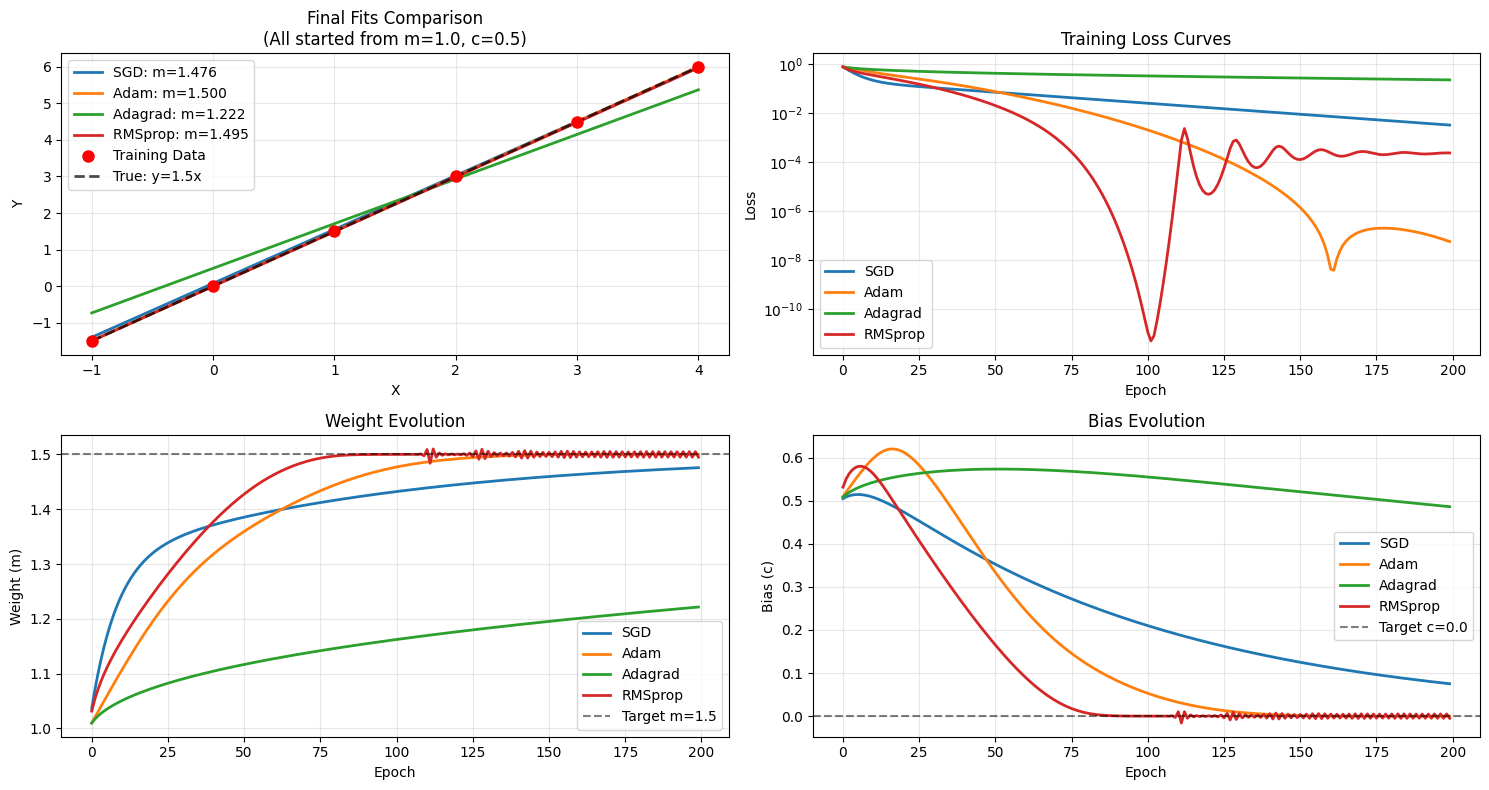

In [7]:
# FIXED: Method 2 with proper optimizer handling
def create_model_with_fixed_weights(initial_weight=1.0, initial_bias=0.5):
    """Create model with specific initial weights"""
    model = keras.Sequential([
        keras.Input(shape=(1,)),  # Use Input layer
        layers.Dense(1)
    ])

    # Set specific initial weights
    model.set_weights([
        np.array([[initial_weight]], dtype=np.float32),  # weight
        np.array([initial_bias], dtype=np.float32)  # bias
    ])

    return model


print("\n" + "=" * 50)
print("Method 2: Fixed Initial Weights Comparison")
print("=" * 50)

# Starting point for all optimizers
initial_w, initial_b = 1.0, 0.5
print(f"Starting from: m = {initial_w}, c = {initial_b}")
print(f"Target values:  m = 1.5000, c = 0.0000")
print("-" * 50)

# Figure 1: Comparison plots
plt.figure(figsize=(15, 8))

# Plot 1: Final results comparison
plt.subplot(2, 2, 1)
for idx, name in enumerate(optimizer_names):
    # Create model with fixed initial weights
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer instance
    model.compile(optimizer=optimizer, loss='mse')

    # Train
    history = model.fit(train_X, train_Y, epochs=epochs, verbose=0)

    # Get results
    final_weight = model.get_weights()[0][0][0]
    final_bias = model.get_weights()[1][0]
    final_loss = history.history['loss'][-1]

    print(f"{name:8s}: m = {final_weight:7.4f}, c = {final_bias:7.4f}, final_loss = {final_loss:.6f}")

    # Plot final fit
    predictions = model.predict(train_X, verbose=0)
    plt.plot(train_X, predictions, '-', label=f'{name}: m={final_weight:.3f}', linewidth=2)

plt.plot(train_X, train_Y, 'ro', label='Training Data', markersize=8, zorder=5)
plt.plot(train_X, 1.5 * train_X + 0, 'k--', label='True: y=1.5x', linewidth=2, alpha=0.7)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Final Fits Comparison\n(All started from m=1.0, c=0.5)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss curves comparison
plt.subplot(2, 2, 2)
for idx, name in enumerate(optimizer_names):
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(train_X, train_Y, epochs=epochs, verbose=0)
    plt.plot(history.history['loss'], label=name, linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Weight evolution comparison
plt.subplot(2, 2, 3)
for idx, name in enumerate(optimizer_names):
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer
    model.compile(optimizer=optimizer, loss='mse')

    # Track weight evolution
    weights_history = []
    for epoch in range(epochs):
        history = model.fit(train_X, train_Y, epochs=1, verbose=0)
        weights_history.append(model.get_weights()[0][0][0])

    plt.plot(range(epochs), weights_history, label=name, linewidth=2)

plt.axhline(y=1.5, color='k', linestyle='--', alpha=0.5, label='Target m=1.5')
plt.xlabel('Epoch')
plt.ylabel('Weight (m)')
plt.title('Weight Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Bias evolution comparison
plt.subplot(2, 2, 4)
for idx, name in enumerate(optimizer_names):
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer
    model.compile(optimizer=optimizer, loss='mse')

    # Track bias evolution
    bias_history = []
    for epoch in range(epochs):
        history = model.fit(train_X, train_Y, epochs=1, verbose=0)
        bias_history.append(model.get_weights()[1][0])

    plt.plot(range(epochs), bias_history, label=name, linewidth=2)

plt.axhline(y=0.0, color='k', linestyle='--', alpha=0.5, label='Target c=0.0')
plt.xlabel('Epoch')
plt.ylabel('Bias (c)')
plt.title('Bias Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('train_curves.png', dpi=300)
plt.show()



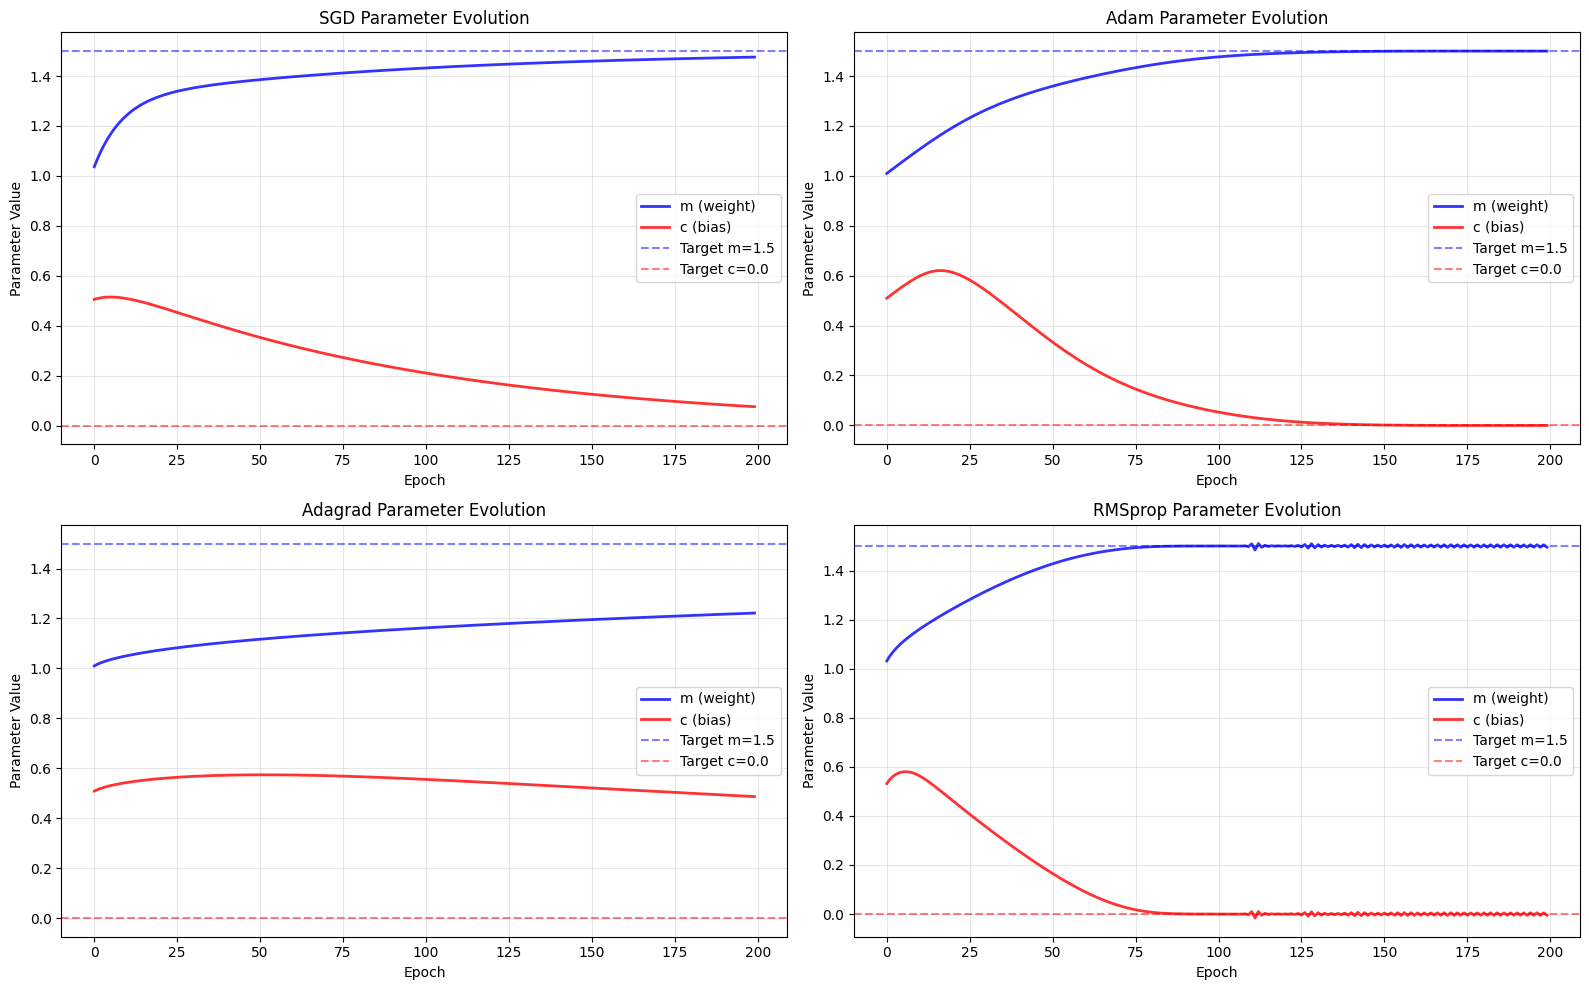


SUMMARY: Convergence Analysis
Optimizer  Final m    Final c    Error m    Error c    Final Loss  
----------------------------------------------------------------------
SGD        1.4758     0.0752     0.0242     0.0752     0.003220    
Adam       1.5001     -0.0003    0.0001     0.0003     0.000000    
Adagrad    1.2215     0.4864     0.2785     0.4864     0.230861    
RMSprop    1.4949     -0.0051    0.0051     0.0051     0.000234    

Key Observations:
• All optimizers converge to m≈1.5, c≈0.0 for this perfect linear data
• SGD: Steady, predictable convergence
• Adam: Fast initial convergence, may overshoot
• Adagrad: Good for sparse data, may slow down over time
• RMSprop: Balanced approach, good for most cases


In [8]:
# Figure 2: Individual optimizer parameter evolution details
plt.figure(figsize=(16, 10))

for idx, name in enumerate(optimizer_names):
    plt.subplot(2, 2, idx + 1)

    # Track parameter evolution during training
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer
    model.compile(optimizer=optimizer, loss='mse')

    weights_history = []
    bias_history = []
    loss_history = []

    for epoch in range(epochs):
        history = model.fit(train_X, train_Y, epochs=1, verbose=0)
        weights_history.append(model.get_weights()[0][0][0])
        bias_history.append(model.get_weights()[1][0])
        loss_history.append(history.history['loss'][0])

    # Plot parameter evolution
    epochs_range = range(epochs)
    plt.plot(epochs_range, weights_history, 'b-', label='m (weight)', alpha=0.8, linewidth=2)
    plt.plot(epochs_range, bias_history, 'r-', label='c (bias)', alpha=0.8, linewidth=2)
    plt.axhline(y=1.5, color='b', linestyle='--', alpha=0.5, label='Target m=1.5')
    plt.axhline(y=0.0, color='r', linestyle='--', alpha=0.5, label='Target c=0.0')
    plt.xlabel('Epoch')
    plt.ylabel('Parameter Value')
    plt.title(f'{name} Parameter Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('parameters.png', dpi=300)
plt.show()

# Summary comparison table
print("\n" + "=" * 70)
print("SUMMARY: Convergence Analysis")
print("=" * 70)
print(f"{'Optimizer':<10} {'Final m':<10} {'Final c':<10} {'Error m':<10} {'Error c':<10} {'Final Loss':<12}")
print("-" * 70)

for name in optimizer_names:
    model = create_model_with_fixed_weights(initial_w, initial_b)
    optimizer = get_optimizer(name)  # Fresh optimizer
    model.compile(optimizer=optimizer, loss='mse')
    model.fit(train_X, train_Y, epochs=epochs, verbose=0)

    final_w = model.get_weights()[0][0][0]
    final_c = model.get_weights()[1][0]
    error_w = abs(final_w - 1.5)
    error_c = abs(final_c - 0.0)
    final_loss = model.evaluate(train_X, train_Y, verbose=0)

    print(f"{name:<10} {final_w:<10.4f} {final_c:<10.4f} {error_w:<10.4f} {error_c:<10.4f} {final_loss:<12.6f}")

print("\nKey Observations:")
print("• All optimizers converge to m≈1.5, c≈0.0 for this perfect linear data")
print("• SGD: Steady, predictable convergence")
print("• Adam: Fast initial convergence, may overshoot")
print("• Adagrad: Good for sparse data, may slow down over time")
print("• RMSprop: Balanced approach, good for most cases")